<a href="https://colab.research.google.com/github/Quantium/Named-Entity-Recognition-NER-con-LSTM-Bidireccionales/blob/main/Notebooks/Reconocimiento_de_Entidades_Nombradas_mediante_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANTE: Cambiar el entorno de ejecución para trabajar con GPU

<h1> RECONOCIMIENTIO DE ENTIDADES NOMBRADAS

(NER, Named-Entity-Recognition)

* El término de **entidades nombradas** fue acuñado por primera vez en 1995 para referirse al proceso de extraer unidades relevantes de información a partir de textos no estructurados..
* Estas unidades incluyen nombres propios de personas, organizaciones, lugares o expresiones numéricas como fechas o
cantidades, etc.
*  El REN se utiliza en sistemas de Pregunta-Respuesta (QA), la generación de resúmenes automáticos, la mejora de los sistemas de recuperación de la información, la traducción automática, la anonimización de textos, la generación de
grafos de conocimientos, etc.
* En los últimos años, el uso de las redes neuronales con el aprendizaje profundo y la integración de modelos del lenguaje con los WordEmbeddings ha supuesto un cambio en el
paradigma del PLN en general y en las tareas específicas como NER


# 1.Cargar bibliotecas

In [1]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 76.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim  # para cargar modelo w2v
from collections import Counter
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model


# 2.Leer Datos

In [3]:
csv_file ="https://raw.githubusercontent.com/Quantium/Named-Entity-Recognition-NER-con-LSTM-Bidireccionales/main/Datos/ner_datasetreference.csv"
data = pd.read_csv(csv_file, encoding= 'unicode_escape', usecols =[0,1,3])
data = data.ffill(axis=0)  # copia en los NaN la última observación válida, hasta encontrar la siguiente.
print(data.shape)
data.head()

(1048575, 3)


,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [4]:
data.head(30)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [5]:
data.nunique()  # Valores únicos en cada columna

,0
Sentence #,47959
Word,35177
Tag,17


In [6]:
data.Tag.value_counts()

,count
Tag,
O,887908
B-geo,37644
B-tim,20333
B-org,20143
I-per,17251
B-per,16990
I-org,16784
B-gpe,15870
I-geo,7414


* geo - Geographical Entity
* gpe - Geopolitical Entity
* per - Person
* org - Organization
* tim - Time indicator
* art - Artifact
* eve - Event
* nat - NaturalPhenomenon

[Inside-Outside-Beginning (tagging)](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging))

In [7]:
data[data['Sentence #']=="Sentence: 35"]

,Sentence #,Word,Tag
790,Sentence: 35,Hardline,O
791,Sentence: 35,lawmakers,O
792,Sentence: 35,in,O
793,Sentence: 35,Pakistan,B-geo
794,Sentence: 35,'s,O
795,Sentence: 35,North,B-geo
796,Sentence: 35,West,I-geo
797,Sentence: 35,Frontier,I-geo
798,Sentence: 35,Province,I-geo
799,Sentence: 35,have,O


# Preprocesamiento

Una rnn se ve beneficiada por el contexto en el que aparecen las palabras, por lo que no es recomendable eliminar stopwords ni normalizarlas mediante radicalización (steaming) o lematización.

Por otro lado, es necesario considerar que el modelo w2v que utilizaremos:
- distingue mayusculas y minúsculas, de manera que el vector asociadao a **Apple** es cercano a los vectpres correspondientes a las palabras  cercanos a "Microsoft", "Google", "iPhone" mientras que **apple** tiene vector cercano al de las palabras "banana", "fruit", "red"...
- no considera vectores para puntuación, ni para números.

In [8]:
# Vamos a filtrar puntuaciónes y números de nuestro dataset
import string
is_punct = data['Word'].isin(list(string.punctuation))

def is_numeric(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

is_number = data['Word'].apply(is_numeric)

df = data[~(is_punct | is_number)].copy()
# df = data[~(is_number)].copy()
print(df.shape)
df[df['Sentence #']=="Sentence: 35"]

(946394, 3)


,Sentence #,Word,Tag
790,Sentence: 35,Hardline,O
791,Sentence: 35,lawmakers,O
792,Sentence: 35,in,O
793,Sentence: 35,Pakistan,B-geo
794,Sentence: 35,'s,O
795,Sentence: 35,North,B-geo
796,Sentence: 35,West,I-geo
797,Sentence: 35,Frontier,I-geo
798,Sentence: 35,Province,I-geo
799,Sentence: 35,have,O


## 2.1.Pasar de tokens por renglón a la secuencia completa de la oración por renglón.

In [9]:
df['Sentence #'] = df['Sentence #'].astype(str).str.replace('Sentence: ','').astype(int)
sentences = df.groupby(['Sentence #'],
                         as_index=False ).agg(lambda x: ' '.join(x))
sentences.columns=['ID', 'Sentence', 'Tags']

sentences.head(5)

,ID,Sentence,Tags
0,1,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,2,Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O B-per O O O ...
2,3,They marched from the Houses of Parliament to ...,O O O O O O O O O O O B-geo I-geo
3,4,"Police put the number of marchers at 10,000 wh...",O O O O O O O O O O O O O O
4,5,The protest comes on the eve of the annual con...,O O O O O O O O O O O B-geo O O B-org I-org O ...


# 3.Identificar cada token y cada etiqueta con un valor numérico

In [10]:
# TOKEN-INDEX

# modificamos el filtro que por default Tonkenizer utiliza para borrar puntuación
#  '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

custom_filters = ''
tokenizer = Tokenizer(filters=custom_filters, lower=False)
tokenizer.fit_on_texts(sentences['Sentence'])


token_index = tokenizer.word_index
token_index['PAD_TOKEN'] = 0


# TAG_INDEX

tokenizer_tags = Tokenizer(filters=custom_filters, lower=False)
tokenizer_tags.fit_on_texts(sentences['Tags'])

tag_index = tokenizer_tags.word_index
tag_index['PAD_TAG'] = 0

In [11]:
# tokenizer reserva el indice 0 para padding y posibels tokens OOV (Out-of-vocabulary)
tag_index

{'O': 1,
 'B-geo': 2,
 'B-org': 3,
 'I-per': 4,
 'B-per': 5,
 'B-tim': 6,
 'I-org': 7,
 'B-gpe': 8,
 'I-geo': 9,
 'I-tim': 10,
 'B-art': 11,
 'B-eve': 12,
 'I-art': 13,
 'I-eve': 14,
 'B-nat': 15,
 'I-gpe': 16,
 'I-nat': 17,
 'PAD_TAG': 0}

In [12]:
token_index['PAD_TOKEN']

0

In [13]:
sentences['Sentence_idx'] = tokenizer.texts_to_sequences(sentences['Sentence'])
sentences['Tags_idx'] = tokenizer_tags.texts_to_sequences(sentences['Tags'])
sentences

,ID,Sentence,Tags,Sentence_idx,Tags_idx
0,1,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...,"[1075, 2, 1120, 14, 1785, 222, 463, 4, 516, 1,...","[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, ..."
1,2,Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O B-per O O O ...,"[8600, 2, 138, 34, 3, 1, 498, 1060, 1, 633, 50...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,3,They marched from the Houses of Parliament to ...,O O O O O O O O O O O B-geo I-geo,"[197, 1785, 19, 1, 14959, 2, 2103, 4, 5, 1260,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 9]"
3,4,"Police put the number of marchers at 10,000 wh...",O O O O O O O O O O O O O O,"[254, 686, 1, 261, 2, 7961, 21, 2038, 196, 395...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,5,The protest comes on the eve of the annual con...,O O O O O O O O O O O B-geo O O B-org I-org O ...,"[7, 516, 527, 12, 1, 3844, 2, 1, 938, 509, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, ..."
...,...,...,...,...,...
47954,47955,Indian border security forces are accusing the...,B-gpe O O O O O O B-gpe O O O O O O O O O B-geo O,"[358, 179, 89, 74, 26, 2166, 54, 251, 4041, 2,...","[8, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, ..."
47955,47956,Indian officials said no one was injured in Sa...,B-gpe O O O O O O O B-tim O O O O O O O O O O ...,"[358, 38, 16, 127, 60, 17, 518, 3, 87, 8, 433,...","[8, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, ..."
47956,47957,Two more landed in fields belonging to a nearb...,O O O O O O O O O O,"[668, 46, 2742, 3, 3161, 3407, 4, 5, 1181, 790]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
47957,47958,They say not all of the rockets exploded upon ...,O O O O O O O O O O,"[197, 22, 36, 155, 2, 1, 1394, 723, 1455, 1982]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


# 4.Preparar las secuencias que ingresarán a nuestra red neuronal.

Padding: Las capas de LSTM necesitan que cada secuencias (oración) tenga la misma longitud, se puede usar cualquier longitud, pero entre más grande sea mayor será el costo del entrenamiento.

Las oraciones  que sean más cortas se "rellenaran" con el token que agregamos anterioremente ('PAD_token')


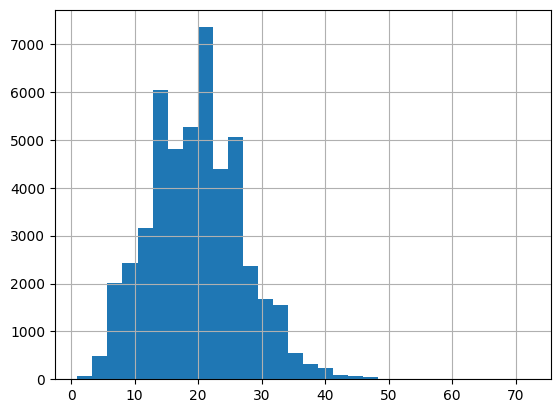

La oración más larga tiene 72 tokens


In [14]:

palabras_sentencia = sentences['Sentence'].apply(lambda x: len(str(x).split()))

palabras_sentencia.hist(bins=30)
plt.show()
print('La oración más larga tiene {} tokens'.format(palabras_sentencia.max()))

In [15]:
max_len = int(palabras_sentencia.quantile(0.95))
max_len

32

In [16]:
# Rellenar con ceros a la máxima longitud de los textos
pad_tokens = pad_sequences(sentences['Sentence_idx'], maxlen=max_len,
                           dtype='int32', padding='post',
                           )
pad_tags = pad_sequences(sentences['Tags_idx'], maxlen=max_len,
                         dtype='int32', padding='post',
                         )

# Hacemos un One Hot Encoding para la secuencia de etiquetas
pad_tags = [to_categorical(i, num_classes=18) for i in pad_tags]

## Ejemplo

In [17]:
ej = 9

print(
f'''
Longitud sentence_idx: {len(sentences.loc[ej, 'Sentence_idx'])}
Longitud tags_idx: {len(sentences.loc[ej, 'Tags_idx'])}


{sentences.loc[ej, "Sentence"]}
{sentences.loc[ej, "Sentence_idx"]}

{sentences.loc[ej, "Tags"]}
{sentences.loc[ej, "Tags_idx"]}
'''
)


Longitud sentence_idx: 23
Longitud tags_idx: 23


Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday after an IAEA surveillance system begins functioning
[309, 38, 22, 52, 1764, 4, 735, 998, 4, 4533, 3245, 763, 2, 1, 1137, 80, 41, 25, 1642, 2204, 455, 2205, 6158]

B-gpe O O O O O O O O O O O O O O B-tim O O B-org O O O O
[8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 3, 1, 1, 1, 1]



In [18]:
pad_tokens[ej]

array([ 309,   38,   22,   52, 1764,    4,  735,  998,    4, 4533, 3245,
        763,    2,    1, 1137,   80,   41,   25, 1642, 2204,  455, 2205,
       6158,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [19]:
# Categóricall
for token, tag in zip(pad_tokens[ej], pad_tags[ej]):
    print('%s\t%s' % (token, tag))

309	[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
38	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
22	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
52	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1764	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
735	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
998	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4533	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3245	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
763	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1137	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
80	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
41	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

# 5.Obtener la matriz de encajes para todas las palabras del vocabulario

<h2> Modelo Preentrenado Word2Vec<h3>

Utilizaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3 millones de palabras y frases en inglés.
Crea un acceso directo en tu drive del modelo preentrenado que está disponible en este [enlace](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Si es la primera vez que corres el notebook, descomenta las siguientes lineas para cargar el modelo preentrenado completo.

In [22]:
%%time
# asegurate de poner la ruta correcta en donde se ubica el archivo en tu drive
file =  '/content/drive/MyDrive/Bourbaki/w7 Word2Vec/GoogleNews-vectors-negative300.bin.gz'
w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)

CPU times: user 46.3 s, sys: 4.55 s, total: 50.9 s
Wall time: 55.1 s


In [23]:
print('Palabras en el modelo w2v: {:,} '.format(len(w2v.key_to_index)))
print('Dimensiones por embedding: ', w2v.vector_size)

Palabras en el modelo w2v: 3,000,000 
Dimensiones por embedding:  300


<h3> Reducción del diccionario de embeddings para tener solo los tokens presentes en nuestro corpus.

Guardar en pikle
Así no tendremos que volver a cargar todo el modelo word embedding

In [ ]:
dic_tokens_word2vec  = {}
palabras_sin_embedding =[]
for token in token_index:
  try:
    dic_tokens_word2vec[token] = w2v[token]
  except:
    palabras_sin_embedding.append(token)

In [ ]:
# import pickle
# path = '/content/drive/MyDrive/Pikles'
# pickle.dump(dic_tokens_word2vec, open (path + "dic_tokens_ner_w2v.pkl", 'wb'))

In [26]:
# import pickle
# path = '/content/drive/MyDrive/Pikles'
# dic_tokens_word2vec = pickle.load(open(path + "dic_tokens_ner_w2v.pkl", 'rb'))
# palabras_sin_embedding = [tok for tok in token_index if tok not in dic_tokens_word2vec.keys()]


In [ ]:
len(token_index)

In [ ]:
len(palabras_sin_embedding)

In [ ]:
# Tokens más frecuentes sin embbedding en nuestros datos.
frec_tokens = pd.DataFrame.from_dict(tokenizer.word_counts, orient='index')
palabras_sin_embedding_filtered = [tok for tok in palabras_sin_embedding if tok != 'PAD_TOKEN']
frec_tokens.loc[palabras_sin_embedding_filtered].sort_values(by=0, ascending=False).head(35)

In [ ]:

num_tokens = len(token_index.keys())

embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for token, i in token_index.items():
    if token in dic_tokens_word2vec.keys():
       embedding_matrix[i] = dic_tokens_word2vec[token]


In [ ]:
pd.DataFrame(embedding_matrix)

# 6.Dividir en conjunto de entrenamiento y prueba

In [ ]:
train_tokens, test_tokens, train_tags, test_tags = train_test_split(
pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

print(
f'''train_tokens: {len(train_tokens)}
train_tags: {len(train_tags)}

test_tokens: {len(test_tokens)}
test_tags: {len(test_tags)}'''
)

# 7.Construcción de la Arquitectura del Modelo


- **Embedding layer** : Será la primera capa de nuestro modelo en el que ingresaremos las secuencias todas de tamaño 32. Esta capa no la entrenaremos (training = False), sino que en su lugar la alimentaremos con la matriz de embedings que preparamos en el paso 5. La salida de esa capa será un tensor de tres dimensiones para alimentar a la capa LSTM [Bath size, timesteps, features] que en nuestro caso se traducirá en [None, 32, 300]

- **Bidirectional LSTM** : Tomará la salida de la capa de embedings y concatenará las salidas de las dos direcciones del LSTM, cada salida tendra las unidades que se declaren en la capa LSTM (128) y al concatenarse, la salida será del doble de unidades (None, 32, 256)

- **TimeDistributed  Layer** : La arquitectura de nuestra RNN es de tipo muchas a muchas, en donde para cada token (timestep) de la secuencia de entrada, esperamos la probabilidad de pertenencia a cada  una de las clases. Para ello se usa esta capa activada por la función 'Softmax'. La salida de esta capa será un tensor de (None, 32, 17)

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [40]:
%%time
input = Input(shape = (max_len,))

# Capa de Embedding
embedding = Embedding(input_dim = num_tokens,
                      output_dim = 300,
                      embeddings_initializer = Constant(embedding_matrix),
                      trainable=False)(input)
# Capa 1 LSTM Bidireccional
LSTM_Bi = Bidirectional(LSTM(units=128,
                             return_sequences=True, # Todos los estados h para cada timestep
                             recurrent_dropout=0.2, dropout=0.2  # Para evitar sobreajuste
                             ))(embedding)
# Capa de Salida
out = TimeDistributed(
    Dense(18,               # dimensiones de salida (17 clases de los Tags + PAD_TAG)
          activation="softmax"  # para obtener una probabilidad para cada clase
                                # función de activación
                                # https://www.tensorflow.org/api_docs/python/tf/keras/activations
          ))(LSTM_Bi)

NER_model = Model(input, out)  # unión del modelo
NER_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 32, 300)        │    10,222,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32, 256)        │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 32, 18)         │         4,626 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,666,422 (40.69 MB)

 Trainable params: 443,922 (1.69 MB)

 Non-trainable params: 10,222,500 (39.00 MB)

CPU times: user 157 ms, sys: 116 ms, total: 273 ms
Wall time: 180 ms


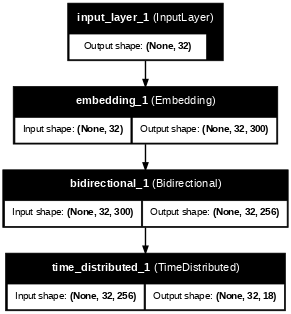

In [41]:
plot_model(
    NER_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

# 8.Entrenamiento del modelo

In [42]:
%%time
# Compile model
NER_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

CPU times: user 6.04 ms, sys: 52 µs, total: 6.09 ms
Wall time: 5.61 ms


In [43]:
type(train_tags)

list

In [44]:
%%time
history = NER_model.fit(train_tokens, np.array(train_tags),
                        validation_split=0.2,
                        batch_size=200,
                        epochs=10,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/step - accuracy: 0.8010 - loss: 0.9102 - val_accuracy: 0.9591 - val_loss: 0.1672
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 31s 178ms/step - accuracy: 0.9605 - loss: 0.1576 - val_accuracy: 0.9678 - val_loss: 0.1223
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - accuracy: 0.9678 - loss: 0.1227 - val_accuracy: 0.9710 - val_loss: 0.1073
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.9702 - loss: 0.1101 - val_accuracy: 0.9725 - val_loss: 0.0998
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.9716 - loss: 0.1033 - val_accuracy: 0.9735 - val_loss: 0.0949
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - accuracy: 0.9727 - loss: 0.0978 - val_accuracy: 0.9742 - val_loss: 0.0913
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - accuracy: 0.9735 - loss: 0.0939 - val_accuracy: 0.9747 - val_loss: 0.0883
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 31s 177ms/step - accuracy: 0.9740 - loss: 0

In [45]:
# Guardar todo el modelo  https://www.tensorflow.org/tutorials/keras/save_and_load
NER_model.save_weights('/content/drive/MyDrive/Modelos/Weights_NER_oct25.weights.h5')

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = '/content/drive/MyDrive/Modelos/Weights_NER_oct25.weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [ ]:
# Leer el modelo guardado
NER_model.load_weights('/content/drive/MyDrive/Modelos/Weights_NER_oct25.weights.h5')

# 9.Predicción y Evaluación

In [ ]:
test_pred = NER_model.predict(np.array(test_tokens), verbose=1)

In [ ]:
# Dimensiones de entrada
test_tokens[0]

In [ ]:
# Dimensiones de salida
test_pred.shape

In [ ]:
test_pred[0].shape

In [ ]:
pd.DataFrame(test_pred[0])

In [ ]:
test_tokens[0:2] # Primeras dos secuencias de entrada en test

In [ ]:
 test_tokens[0,1] #  M[i, j]

In [ ]:
test_tokens.shape

In [ ]:
# Obtener el diccionario index_token
index_token = {idx: token for token, idx in token_index.items()}

# Obtener el diccionario index_tag
index_tag = {i: w for w, i in tag_index.items()}


In [ ]:
def secIdx2secTok(M):
  '''
  Obtiene para cada secuencia de tokens codificada con un indice,
  la secuencia de tokens decodificada
  Argumentos:
  ----------
  M: Matriz de la forma (n_sec, max_len)

  Regresa las secuencias de tokens decodificada.'''

  n = M.shape[0]
  d = M.shape[1]
  oraciones = []
  for i in range(n):
      tokens = []
      for j in range(d):
          idx = M[i, j]
          tokens.append(index_token[idx])
      oraciones.append(tokens)
  return oraciones

test_toks = secIdx2secTok(test_tokens)


In [ ]:

def secIdx2secTag(tensor_tag):
    '''
    Obtiene para cada secuencia de etiquetas codificada con un indice,
    la secuencia de etiquetas decodificadas.
    Argumentos:
    ----------
    tensor_tag: un tensor de la forma (n_sec, max_len, 18)

    Regresa las secuencias de etiquetas decodificada.
    '''
    lista_sec_decodificadas = []
    for sec in tensor_tag:
        tags = []
        for p in sec:
            inx = np.argmax(p)
            tags.append(index_tag[inx])
        lista_sec_decodificadas.append(tags)
    return lista_sec_decodificadas

pred_labels = secIdx2secTag(test_pred)
test_labels = secIdx2secTag(test_tags)

In [ ]:
dfs = {}
for idx in range(len(test_labels)):
  dfs[idx] = pd.DataFrame({'ID': idx,
                           'Word': test_toks[idx],
                           'Tag':test_labels[idx],
                           'Pred':pred_labels[idx]})

resultados = pd.concat(dfs, ignore_index = True).set_index('ID')
resultados = resultados[resultados['Word']!='PAD_TOKEN']
resultados['acierto'] = np.where(resultados['Pred']==resultados['Tag'],1,0)
resultados['acierto'].mean()

In [ ]:
resultados.loc[312]  # 4 , 8 , 87

# Referencias

1. Karakaya M. LSTM: Understanding Output Types [Internet]. Deep Learning Tutorials with Keras. 2021 [citado 14 de julio de 2022]. Disponible en: https://www.muratkarakaya.net/2022/11/lstm-understanding-output-types.html



2. Nair S. Named-Entity Recognition (NER) using Keras Bidirectional LSTM [Internet]. Medium. 2020 [citado 14 de julio de 2022]. Disponible en: https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54

3. Samy D. Reconocimiento y clasificación de entidades nombradas en textos legales en español. Procesamiento del Lenguaje Natural. 2021;103-14.

4. Sarkar S. Named Entity Recognition using Deep Learning(ELMo Embedding+ Bi-LSTM) [Internet]. Analytics Vidhya. 2021 [citado 14 de julio de 2022]. Disponible en: https://medium.com/analytics-vidhya/named-entity-recognition-using-deep-learning-elmo-embedding-bi-lstm-48295bc66cab







